## Mount Google Drive to Colab and import packages

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
!pip install rasterio

In [7]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib
from tqdm.notebook import tqdm
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Create Dataframe (Df) Master

In [8]:
# Function for reading data from Google Drive folders and returning a df
def read_data(folders): 
    X = []
    for folder in folders:
#         files_s = glob.glob(f"./{folder}/*all*.tif")
        files_s = glob.glob(f"/content/drive/MyDrive/LeWagon_Project_Data/data/{folder}/*all*.tif")
        for file in files_s:
            print(files_s)
#             filename = os.path.basename(f"./{folder}/{file}")
            filename = os.path.basename(f"/content/drive/MyDrive/LeWagon_Project_Data/data/{folder}/{file}")

            file_id, date = filename.split('_all_bands_')
            date = date.replace('.tif','')
            d = {
                'date': date,
                'id': file_id,
                'filename': filename,
                'label': folder
            }
            X.append(d)
    return pd.DataFrame(X)

In [9]:
# Read files and file info into df from folders
# %%time
df = read_data(['rice_1y', 'sugarcane'])
df

""


In [10]:
# Function for opening and loading tif image files
def load_tif(file):
    img = rasterio.open(file).read()
    return img

In [11]:
# df['new_filename'] = './' + df['label'] + '/' + df['filename']
df['new_filename'] = '/content/drive/MyDrive/LeWagon_Project_Data/data/' + df['label'] + '/' + df['filename']

KeyError: 'label'

In [8]:
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [9]:
%%time
df['bands'] = df['new_filename'].progress_apply(load_tif)


CPU times: user 1min 5s, sys: 19.7 s, total: 1min 24s
Wall time: 43min 1s


In [10]:
# Formulas and Computations for Band Combinations and Bands 

combinations = {
    'ndvi': lambda band: (band[8]-band[4])/(band[8] + band[4]), #Compute NDVI
    'mi': lambda band: (band[8]-band[11])/(band[8] + band[11]), #Compute Moisture Index (mi)
    'bc1': lambda band: band[7] + band[6] + band[4], #Compute BC1 (SWIR-1)
    'bc2': lambda band: band[11] + band[8] + band[2], #Compute BC2 (Agriculture)
    'bc3': lambda band: (band[3]-band[8])/(band[3] + band[8]), #Compute BC3 (NWDI)
    'bc4': lambda band: band[12] + band[8] + band[4], #Compute BC4 (SWIR-2)
    'bc5': lambda band: band[4] + band[3] + band[2], #Compute BC5 (Natural Color)
    'bc6': lambda band: (band[8]-band[3])/(band[8] + band[3]), #Compute BC6 (GNDVI)
    'bc8': lambda band: (band[8] * (1 - band[4])*(band[8] - band[4]))**(1/3), #Compute BC8 (AVI)
    'bc9': lambda band: (band[8] - band[4]) / (band[8] + band[4] + 0.428) * (1.428), #Compute BC9 (SAVI)
    'bc10': lambda band: band[11] / band[8], #Compute BC10 (MSI)
    'bc11': lambda band: (band[9] / band[3])-1, #Compute BC11 (GCI)
    'bc12': lambda band: (band[8]-band[12])/(band[8] + band[12]), # Compute BC12 (NBRI)
    'bc13': lambda band: ((band[11] + band[4]) - (band[8] + band[2])) / ((band[11] + band[4]) + (band[8] + band[2])), #Compute BC13 (BSI)
    'bc14': lambda band: (band[3]-band[11])/(band[3] + band[11]), # Compute BC14 (NDSI)
    'bc15': lambda band: (band[3]-band[4])/(band[3] + band[4]) # Compute BC15 (NDGI)
    }
for i in range(13):
  combinations[f'b{i}'] = lambda band: band[i]

In [11]:
#Compute means, medians, and standard deviations for band combinations and bands

for combo, func in combinations.items():
    print(f'Computing features for {combo}')
    bb = df['bands'].apply(func)
    df[f'{combo}_mean'] = bb.apply(np.nanmean)
    df[f'{combo}_std'] = bb.apply(np.nanstd)
    df[f'{combo}_median'] = bb.apply(np.nanmedian)

Computing features for ndvi
Computing features for mi
Computing features for bc1
Computing features for bc2
Computing features for bc3
Computing features for bc4
Computing features for bc5
Computing features for bc6
Computing features for bc8
Computing features for bc9
Computing features for bc10
Computing features for bc11
Computing features for bc12
Computing features for bc13
Computing features for bc14
Computing features for bc15
Computing features for b0
Computing features for b1
Computing features for b2
Computing features for b3
Computing features for b4
Computing features for b5
Computing features for b6
Computing features for b7
Computing features for b8
Computing features for b9
Computing features for b10
Computing features for b11
Computing features for b12


In [12]:
# Check columns
df.columns

Index(['date', 'id', 'filename', 'label', 'new_filename', 'bands', 'ndvi_mean',
       'ndvi_std', 'ndvi_median', 'mi_mean', 'mi_std', 'mi_median', 'bc1_mean',
       'bc1_std', 'bc1_median', 'bc2_mean', 'bc2_std', 'bc2_median',
       'bc3_mean', 'bc3_std', 'bc3_median', 'bc4_mean', 'bc4_std',
       'bc4_median', 'bc5_mean', 'bc5_std', 'bc5_median', 'bc6_mean',
       'bc6_std', 'bc6_median', 'bc8_mean', 'bc8_std', 'bc8_median',
       'bc9_mean', 'bc9_std', 'bc9_median', 'bc10_mean', 'bc10_std',
       'bc10_median', 'bc11_mean', 'bc11_std', 'bc11_median', 'bc12_mean',
       'bc12_std', 'bc12_median', 'bc13_mean', 'bc13_std', 'bc13_median',
       'bc14_mean', 'bc14_std', 'bc14_median', 'bc15_mean', 'bc15_std',
       'bc15_median', 'b0_mean', 'b0_std', 'b0_median', 'b1_mean', 'b1_std',
       'b1_median', 'b2_mean', 'b2_std', 'b2_median', 'b3_mean', 'b3_std',
       'b3_median', 'b4_mean', 'b4_std', 'b4_median', 'b5_mean', 'b5_std',
       'b5_median', 'b6_mean', 'b6_std', 'b6_med

In [ ]:
# Check df information
df.info()

In [19]:
# Rename label column to target
df = df.rename(columns={'label': 'target'})

In [20]:
# Save the full (no edits) df file to csv format for sharing/later use
df.to_csv(r'/content/drive/MyDrive/LeWagon_Project_Data/dataframe.csv', index=False)

In [21]:
# Create a copy of the df for further edits
df3 = df.copy()

In [22]:
# Drop unneeded columns (determined after using PCA for dimensionality reduction)
df3 = df3.drop(columns = ['filename','new_filename','bands','bc4_mean', 'bc4_std',
       'bc4_median', 'bc5_mean', 'bc5_std', 'bc5_median', 'bc6_mean',
       'bc6_std', 'bc6_median', 'bc8_mean', 'bc8_std', 'bc8_median',
       'bc9_mean', 'bc9_std', 'bc9_median', 'bc10_mean', 'bc10_std',
       'bc10_median', 'bc11_mean', 'bc11_std', 'bc11_median', 'bc12_mean',
       'bc12_std', 'bc12_median', 'bc13_mean', 'bc13_std', 'bc13_median',
       'bc14_mean', 'bc14_std', 'bc14_median', 'bc15_mean', 'bc15_std',
       'bc15_median'])

In [23]:
# Check df after dropping unneeded columns
df3.head(10)

,date,id,target,ndvi_mean,ndvi_std,ndvi_median,mi_mean,mi_std,mi_median,bc1_mean,bc1_std,bc1_median,bc2_mean,bc2_std,bc2_median,bc3_mean,bc3_std,bc3_median,b0_mean,b0_std,b0_median,b1_mean,b1_std,b1_median,b2_mean,b2_std,b2_median,b3_mean,b3_std,b3_median,b4_mean,b4_std,b4_median,b5_mean,b5_std,b5_median,b6_mean,b6_std,b6_median,b7_mean,b7_std,b7_median,b8_mean,b8_std,b8_median,b9_mean,b9_std,b9_median,b10_mean,b10_std,b10_median,b11_mean,b11_std,b11_median,b12_mean,b12_std,b12_median
0,2020-11-26,id_6094c0dcf85c5e001b870958,rice_1y,13.956899,4.955790,15.168133,0.219889,0.006063,0.220674,4227.337461,2888.531031,5938.0,3565.839009,2437.854674,4977.0,14.548170,6.068069,16.429864,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0,0.684211,0.464830,1.0
1,2020-10-17,id_6094f7b0f85c5e001b870a58,rice_1y,7.046988,0.039895,7.046457,0.434103,0.002141,0.434049,9729.166667,6559.714570,14091.0,7754.701389,5228.446900,11244.5,5.464991,3.005370,7.108566,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0
2,2021-03-31,id_6094f9e4f85c5e001b870a67,rice_1y,0.231467,0.020570,0.226649,0.205430,0.049781,0.197099,3511.595728,4223.824594,0.0,2956.810069,3560.606906,0.0,12.328034,1.125299,11.921317,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0
3,2020-11-06,id_60a09545f85c5e001b8714ba,rice_1y,6.065254,0.038709,6.075087,0.421100,0.002359,0.420999,4414.242798,7210.398763,0.0,3371.440329,5506.992218,0.0,0.018941,0.005283,0.019878,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0
4,2020-07-09,id_609ded90f85c5e001b871242,rice_1y,0.540935,0.019682,0.545061,0.643992,0.021339,0.648356,7088.322917,4791.600980,10194.0,4778.677083,3226.829889,6838.0,11.060211,0.361530,11.047623,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0,0.687500,0.463512,1.0
5,2020-11-01,id_6094f9e4f85c5e001b870a67,rice_1y,34.896271,4.016686,35.126486,0.290243,0.048562,0.280077,1141.238749,1382.447736,0.0,857.377574,1032.293142,0.0,1.551633,6.263238,0.236062,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0,0.410374,0.491902,0.0
6,2020-09-17,id_60a091c6f85c5e001b871494,rice_1y,0.137017,0.051346,0.125220,0.319251,0.047857,0.300284,3490.623932,2159.312393,4429.0,2777.410256,1698.665233,3617.0,22.667219,2.072036,23.036989,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0,0.735043,0.441310,1.0
7,2021-04-25,id_60a091c6f85c5e001b871494,rice_1y,0.099770,0.077576,0.074518,0.295592,0.066712,0.281226,3076.940171,1931.980819,3953.0,2560.256410,1606.439154,3338.0,24.

In [25]:
# Find duplicates in the dates column
df3[df3['date'].str.contains('(1)', regex=False)]

,date,id,target,ndvi_mean,ndvi_std,ndvi_median,mi_mean,mi_std,mi_median,bc1_mean,bc1_std,bc1_median,bc2_mean,bc2_std,bc2_median,bc3_mean,bc3_std,bc3_median,b0_mean,b0_std,b0_median,b1_mean,b1_std,b1_median,b2_mean,b2_std,b2_median,b3_mean,b3_std,b3_median,b4_mean,b4_std,b4_median,b5_mean,b5_std,b5_median,b6_mean,b6_std,b6_median,b7_mean,b7_std,b7_median,b8_mean,b8_std,b8_median,b9_mean,b9_std,b9_median,b10_mean,b10_std,b10_median,b11_mean,b11_std,b11_median,b12_mean,b12_std,b12_median
4423,2020-10-23 (1),id_6054a1b458a7cd004800098c,sugarcane,0.468319,0.044709,0.4824,0.476738,0.083605,0.507569,4173.650505,3769.92314,6468.0,3026.955556,2718.519,4950.0,15.626843,1.562874,15.1794,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0,0.555556,0.496904,1.0


In [26]:
#Remove duplicates
df3 = df3.drop(df3.index[4423])

In [27]:
#Add month column, sort df by month
df3['month'] = df3['date'].apply(lambda x : pd.to_datetime(x).month)
df3 = df3.sort_values(by=['month'])

In [ ]:
# Check df information again
df3.info()

In [29]:
# Look at the first 10 columns of the df
df3.head(10)

,date,id,target,ndvi_mean,ndvi_std,ndvi_median,mi_mean,mi_std,mi_median,bc1_mean,bc1_std,bc1_median,bc2_mean,bc2_std,bc2_median,bc3_mean,bc3_std,bc3_median,b0_mean,b0_std,b0_median,b1_mean,b1_std,b1_median,b2_mean,b2_std,b2_median,b3_mean,b3_std,b3_median,b4_mean,b4_std,b4_median,b5_mean,b5_std,b5_median,b6_mean,b6_std,b6_median,b7_mean,b7_std,b7_median,b8_mean,b8_std,b8_median,b9_mean,b9_std,b9_median,b10_mean,b10_std,b10_median,b11_mean,b11_std,b11_median,b12_mean,b12_std,b12_median,month
2714,2021-01-29,id_6054a1b558a7cd00480009c5,sugarcane,0.326887,0.039961,0.333059,0.356040,0.056311,0.370403,6652.833333,2462.498480,7553.5,5229.897959,1934.456072,5927.0,14.665329,0.653275,14.544327,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,1
3307,2021-01-01,id_6054a1b558a7cd00480009cb,sugarcane,0.389033,0.085019,0.370453,0.388601,0.084351,0.389844,5773.906250,3424.335217,7599.0,4326.007812,2560.718544,5744.5,14.795292,0.850183,14.604716,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
2085,2021-01-31,id_6054a1b558a7cd00480009cb,sugarcane,0.231330,0.081022,0.187807,4.498033,5.008589,0.353001,5645.617188,3338.367818,7462.5,5365.093750,3213.801262,7079.5,13.631533,0.898252,13.511060,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
5331,2021-01-16,id_6054a1b558a7cd00480009b0,sugarcane,0.802878,5.477423,0.047894,24.260523,8.707744,26.798188,2048.275815,1866.452851,2513.5,2257.058424,1955.437476,2828.5,33.738232,8.489666,37.437929,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,1
4311,2021-01-19,id_6054a1b558a7cd00480009d7,sugarcane,0.314713,0.077776,0.302136,0.322170,0.149583,0.303254,4964.931429,4011.322661,7860.0,3879.786667,3163.837463,5743.0,13.606075,0.914013,13.754336,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,1
6802,2021-01-06,id_6054a1b558a7cd00480009e3,sugarcane,0.528461,0.065706,0.552931,0.549856,0.105310,0.594061,5339.122051,4305.275204,8524.0,3753.926154,3009.156602,6030.0,13.193283,0.796140,12.985919,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,0.609231,0.487923,1.0,1
2920,2021-01-31,id_6054a1b558a7cd00480009c8,sugarcane,0.157123,0.046440,0.149545,12.815391,8.537201,14.880876,3718.103704,2544.982093,4287.0,3807.925926,2477.865653,4730.0,21.923164,6.569107,19.845847,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,1
2066,2021-01-14,id_6054a1b558a7cd00480009c5,sugarcane,0.485578,0.057883,0.492417,0.513150,0

In [30]:
# Save the edited df file to csv format for sharing/later use
df3.to_csv(r'/content/drive/MyDrive/LeWagon_Project_Data/dataframe3.csv', index=False)

# [Old] Create Df function

In [ ]:
# def create_dataset(folders, n = None): 
#     X = []
#     y = []

    
#     for folder in folders:
#         print(f'starting processing folder {folder}')
#         files_s = glob.glob(f"/content/drive/MyDrive/LeWagon_Project_Data/data/{folder}/*all*.tif")
#         if n is None:
#             n = len(files_s)
#         for file in files_s[:n]:
#             print(f'starting processing file {file}')
#             filename = os.path.basename(f"/content/drive/MyDrive/LeWagon_Project_Data/data/{folder}/{file}")
#             file_id, date = filename.split('_all_bands_')
#             date = date.replace('.tif','')
    
#             img = rasterio.open(file)
#             # Compute ndvi mean, median, std
#             print(f'starting processing ndvi')
#             ndvi = (img.read(8)-img.read(4))/(img.read(8) + img.read(4))
#             ndvi_ = np.nan_to_num(ndvi, nan=-1)
#             ndvi_values = np.array([x for x in ndvi_.flatten() if x != -1])
#             ndvi_mean = ndvi_values.mean()
#             ndvi_median = np.median(ndvi_values)
#             ndvi_std = np.std(ndvi_values)
            
#             # Compute mi mean, median, std
#             print(f'starting processing MI')
#             mi = (img.read(8)-img.read(11))/(img.read(8) + img.read(11))
#             mi_ = np.nan_to_num(mi, nan=-1)
#             mi_values =np.array([x for x in mi_.flatten() if x != -1])
#             mi_mean = mi_values.mean()
#             mi_median = np.median(mi_values)
#             mi_std = np.std(mi_values)

#             # Compute Cb1 mean, median, std
#             print(f'starting processing Cb1')
#             band_combo_1 = img.read(7) + img.read(6) + img.read(4)
#             bc1_ = np.nan_to_num(band_combo_1, nan=-1)
#             bc1_values =np.array([x for x in bc1_.flatten() if x != -1])
#             bc1_mean = bc1_values.mean()
#             bc1_median = np.median(bc1_values)
#             bc1_std = np.std(bc1_values)
            
#             # Compute Cb2 mean, median, std
#             print(f'starting processing Cb2')
#             band_combo_2 = img.read(11) + img.read(8) + img.read(2)
#             bc2_ = np.nan_to_num(band_combo_2, nan=-1)
#             bc2_values =np.array([x for x in bc2_.flatten() if x != -1])
#             bc2_mean= bc2_values.mean()
#             bc2_median= np.median(bc2_values)
#             bc2_std= np.std(bc2_values)
            
#             # Compute Cb3 mean, median, std
#             print(f'starting processing Cb3')
#             band_combo_3 = (img.read(3)-img.read(8))/(img.read(3)+img.read(8))
#             bc3_ = np.nan_to_num(band_combo_3, nan=-1)
#             bc3_values =np.array([x for x in bc3_.flatten() if x != -1])
#             bc3_mean= bc3_values.mean()
#             bc3_median= np.median(bc3_values)
#             bc3_std= np.std(bc3_values)
            
#             # Compute Cb4 mean, median, std
#             print(f'starting processing Cb4')
#             band_combo_4 = img.read(12) + img.read(8) + img.read(4)
#             bc4_ = np.nan_to_num(band_combo_4, nan=-1)
#             bc4_values =np.array([x for x in bc4_.flatten() if x != -1])
#             bc4_mean= bc4_values.mean()
#             bc4_median= np.median(bc4_values)
#             bc4_std= np.std(bc4_values)
            
#             # Compute Cb5 mean, median, std
#             print(f'starting processing Cb5')
#             band_combo_5 = img.read(4) + img.read(3) + img.read(2)
#             bc5_ = np.nan_to_num(band_combo_5, nan=-1)
#             bc5_values =np.array([x for x in bc5_.flatten() if x != -1])
#             bc5_mean= bc5_values.mean()
#             bc5_median= np.median(bc5_values)
#             bc5_std= np.std(bc5_values)
            
#             #Compute GNDVI
#             print(f'starting processing Cb6')
#             band_combo_6 = (img.read(8) - img.read(3))/(img.read(8) + img.read(3))
#             bc6_ = np.nan_to_num(band_combo_6, nan=-1)
#             bc6_values =np.array([x for x in bc6_.flatten() if x != -1])
#             bc6_mean= bc6_values.mean()
#             bc6_median= np.median(bc6_values)
#             bc6_std= np.std(bc6_values)
            
            #Compute EVI
#            EVI (Sentinel 2) = 2.5 * ((B8 – B4) / (B8 + 6 * B4 – 7.5 * B2 + 1))
#            EVI (Sentinel 2) = 2.5 * ((B8 – B4) / (B8 + 6 * B4 – 7.5 * B2 + 1))
#             band_combo_7 = 2.5 *((img.read(8) - img.read(4))/(img.read(8)+6*img.read(4) - 7.5*img.read(2) + 1))
#             bc7_ = np.nan_to_num(band_combo_7, nan=-1)
#             bc7_values =np.array([x for x in bc7_.flatten() if x != -1])
#             bc7_mean= bc7_values.mean()
#             bc7_median= np.median(bc7_values)
#             bc7_std= np.std(bc7_values)
            
#             #Compute AVI 
#             # AVI (Sentinel 2) = [B8 * (1 – B4)*(B8 – B4)]**1/3
#             print(f'starting processing Cb8')
#             band_combo_8 = (img.read(8) * (1 - img.read(4))*(img.read(8) - img.read(4)))**(1/3)
#             bc8_ = np.nan_to_num(band_combo_8, nan=-1)
#             bc8_values =np.array([x for x in bc8_.flatten() if x != -1])
#             bc8_mean= bc8_values.mean()
#             bc8_median= np.median(bc8_values)
#             bc8_std= np.std(bc8_values)
            
#             #Compute SAVI
# #           SAVI (Sentinel 2) = (B08 – B04) / (B08 + B04 + 0.428) * (1.428)
#             print(f'starting processing Cb9')
#             band_combo_9 = (img.read(8) - img.read(4)) / (img.read(8) + img.read(4) + 0.428) * (1.428)
#             bc9_ = np.nan_to_num(band_combo_9, nan=-1)
#             bc9_values =np.array([x for x in bc9_.flatten() if x != -1])
#             bc9_mean= bc9_values.mean()
#             bc9_median= np.median(bc9_values)
#             bc9_std= np.std(bc9_values)
                                                
#             #Compute Cb10 mean, median, std
#             #MSI (Sentinel 2) = B11 / B08
#             print(f'starting processing Cb10')            
#             band_combo_10 = img.read(11) / img.read(8)
#             bc10_ = np.nan_to_num(band_combo_10, nan=-1)
#             bc10_values =np.array([x for x in bc10_.flatten() if x != -1])
#             bc10_mean= bc10_values.mean()
#             bc10_median= np.median(bc10_values)
#             bc10_std= np.std(bc10_values)
                            
#             #Compute Cb11 mean, median, std
#             #GCI (Sentinel 2) = (B9 / B3) -1
#             print(f'starting processing Cb11')
#             band_combo_11 = (img.read(9) / img.read(3)) -1
#             bc11_ = np.nan_to_num(band_combo_11, nan=-1)
#             bc11_values =np.array([x for x in bc11_.flatten() if x != -1])
#             bc11_mean= bc11_values.mean()
#             bc11_median= np.median(bc11_values)
#             bc11_std= np.std(bc11_values)
                            
#             #Compute Cb12 mean, median, std
#             #NBRI (Sentinel 2) = (B8 – B12) / (B8 + B12)
#             print(f'starting processing Cb12')                
#             band_combo_12 = (img.read(8)-img.read(12))/(img.read(8)+img.read(12))
#             bc12_ = np.nan_to_num(band_combo_12, nan=-1)
#             bc12_values =np.array([x for x in bc12_.flatten() if x != -1])
#             bc12_mean= bc12_values.mean()
#             bc12_median= np.median(bc12_values)
#             bc12_std= np.std(bc12_values)

#             # Compute BSI mean, median, std
#             print(f'starting processing Cb13')             
#             band_combo_13 = \
#             ((img.read(11) + img.read(4)) - (img.read(8) + img.read(2))) / \
#             ((img.read(11) + img.read(4)) + (img.read(8) + img.read(2)))
#             bc13_ = np.nan_to_num(band_combo_13, nan=-1) 
#             bc13_values =np.array([x for x in bc13_.flatten() if x != -1]) 
#             bc13_mean= bc13_values.mean() 
#             bc13_median= np.median(bc13_values) 
#             bc13_std= np.std(bc13_values) 

#             # Compute NWDI mean, median, std
#             print(f'starting processing Cb14') 
#             band_combo_14 =  (img.read(3) - img.read(8)) / (img.read(3) + img.read(8)) 
#             bc14_ = np.nan_to_num(band_combo_14, nan=-1) 
#             bc14_values =np.array([x for x in bc14_.flatten() if x != -1]) 
#             bc14_mean= bc14_values.mean() 
#             bc14_median= np.median(bc14_values) 
#             bc14_std= np.std(bc14_values) 

#             # Compute NDSI mean, median, std
#             print(f'starting processing Cb15') 
#             band_combo_15 =  (img.read(3) - img.read(11)) / (img.read(3) + img.read(11)) 
#             bc15_ = np.nan_to_num(band_combo_15, nan=-1) 
#             bc15_values =np.array([x for x in bc15_.flatten() if x != -1]) 
#             bc15_mean= bc15_values.mean() 
#             bc15_median= np.median(bc15_values) 
#             bc15_std= np.std(bc15_values) 

#             # Compute NDGI mean, median, std
#             print(f'starting processing Cb16') 
#             band_combo_16 =  (img.read(3) - img.read(4)) / (img.read(3) + img.read(4)) 
#             bc16_ = np.nan_to_num(band_combo_16, nan=-1) 
#             bc16_values =np.array([x for x in bc16_.flatten() if x != -1]) 
#             bc16_mean= bc16_values.mean() 
#             bc16_median= np.median(bc16_values) 
#             bc16_std= np.std(bc16_values)            


#             #Feature Dictionary
#             b_dict = {'date':date,'file_id':file_id,'target': folder,\
#                       'ndvi_mean': ndvi_mean,'ndvi_median': ndvi_median,'ndvi_std': ndvi_std,\
#                       'mi_mean': mi_mean,'mi_median': mi_median,'mi_std': mi_std,\
#                       'bc1_mean': bc1_mean,'bc1_median': bc1_median,'bc1_std': bc1_std,\
#                       'bc2_mean': bc2_mean,'bc2_median': bc2_median,'bc2_std': bc2_std,\
#                       'bc3_mean': bc3_mean,'bc3_median': bc3_median,'bc3_std': bc3_std,\
#                       'bc4_mean': bc4_mean,'bc4_median': bc4_median,'bc4_std': bc4_std,\
#                       'bc5_mean': bc5_mean,'bc5_median': bc5_median,'bc5_std': bc5_std,\
#                        'bc6_mean': bc6_mean,'bc6_median': bc6_median,'bc6_std': bc6_std,\
# #                        'bc7_mean': bc7_mean,'bc7_median': bc7_median,'bc7_std': bc7_std,\
#                        'bc8_mean': bc8_mean,'bc8_median': bc8_median,'bc8_std': bc8_std,\
#                        'bc9_mean': bc9_mean,'bc9_median': bc9_median,'bc9_std': bc9_std,\
#                        'bc10_mean': bc10_mean,'bc10_median': bc10_median,'bc10_std': bc10_std,\
#                        'bc11_mean': bc11_mean,'bc11_median': bc11_median,'bc11_std': bc11_std,\
#                        'bc12_mean': bc12_mean,'bc12_median': bc12_median,'bc12_std': bc12_std,\
#                        'bc13_mean': bc13_mean,'bc13_median': bc13_median,'bc13_std': bc13_std,\
#                        'bc14_mean': bc14_mean,'bc14_median': bc14_median,'bc14_std': bc14_std,\
#                        'bc15_mean': bc15_mean,'bc15_median': bc15_median,'bc15_std': bc15_std,\
#                        'bc16_mean': bc16_mean,'bc16_median': bc16_median,'bc16_std': bc16_std,
                    
#                     }
            
            # for band in range(1,13):
#               b_dict[f'b{band}'] = img.read(band).flatten()
    #             b_dict[f'b{band}_mean'] = img.read(band).flatten().mean()
    #             b_dict[f'b{band}_median'] = np.median(img.read(band).flatten())
    #             b_dict[f'b{band}_std'] = np.std(img.read(band).flatten())
    #         X.append(b_dict)      
    #         img.close()
    # df = pd.DataFrame(X)
    
    # #Add month columns, sort by month
    # df['month'] = pd.DatetimeIndex(df['date']).month
    # df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    # df = df.sort_values(by=['month'])
    
    # return df

In [ ]:
# folders = ['rice_1y', 'sugarcane']
# df = create_dataset(folders)

In [ ]:
# df = df.drop(columns = ['b1','b2','b3','b4','b5','b6','b7','b8','b9','b10','b11','b12'])

In [ ]:
df.to_csv(r'/content/drive/MyDrive/LeWagon_Project_Data/dataframe3.csv', index=False)

# Read in Dataframe Master (df3) for model training and testing

In [31]:
# Get the df master file to use for model training and testing (ndvi, mi, bc1-bc3, individual bands 1 ~12)
df = pd.read_csv('/content/drive/MyDrive/LeWagon_Project_Data/dataframe3.csv')
df

,date,id,target,ndvi_mean,ndvi_std,ndvi_median,mi_mean,mi_std,mi_median,bc1_mean,bc1_std,bc1_median,bc2_mean,bc2_std,bc2_median,bc3_mean,bc3_std,bc3_median,b0_mean,b0_std,b0_median,b1_mean,b1_std,b1_median,b2_mean,b2_std,b2_median,b3_mean,b3_std,b3_median,b4_mean,b4_std,b4_median,b5_mean,b5_std,b5_median,b6_mean,b6_std,b6_median,b7_mean,b7_std,b7_median,b8_mean,b8_std,b8_median,b9_mean,b9_std,b9_median,b10_mean,b10_std,b10_median,b11_mean,b11_std,b11_median,b12_mean,b12_std,b12_median,month
0,2021-01-29,id_6054a1b558a7cd00480009c5,sugarcane,0.326887,0.039961,0.333059,0.356040,0.056311,0.370403,6652.833333,2462.498480,7553.5,5229.897959,1934.456072,5927.0,14.665329,0.653275,14.544327,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,1
1,2021-01-01,id_6054a1b558a7cd00480009cb,sugarcane,0.389033,0.085019,0.370453,0.388601,0.084351,0.389844,5773.906250,3424.335217,7599.0,4326.007812,2560.718544,5744.5,14.795292,0.850183,14.604716,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
2,2021-01-31,id_6054a1b558a7cd00480009cb,sugarcane,0.231330,0.081022,0.187807,4.498033,5.008589,0.353001,5645.617188,3338.367818,7462.5,5365.093750,3213.801262,7079.5,13.631533,0.898252,13.511060,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
3,2021-01-16,id_6054a1b558a7cd00480009b0,sugarcane,0.802878,5.477423,0.047894,24.260523,8.707744,26.798188,2048.275815,1866.452851,2513.5,2257.058424,1955.437476,2828.5,33.738232,8.489666,37.437929,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,1
4,2021-01-19,id_6054a1b558a7cd00480009d7,sugarcane,0.314713,0.077776,0.302136,0.322170,0.149583,0.303254,4964.931429,4011.322661,7860.0,3879.786667,3163.837463,5743.0,13.606075,0.914013,13.754336,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,2020-12-26,id_60a09545f85c5e001b8714ba,rice_1y,6.889612,4.426219,9.179983,0.097189,0.009057,0.097371,2701.352881,4435.784458,0.0,2550.419753,4187.098316,0.0,9.973318,1.533205,10.034206,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,12
7789,2020-12-05,id_6054a1b558a7cd00480009c8,sugarcane,0.447698,0.063686,0.453211,0.431491,0.095524,0.415568,5331.385185,3299.993786,7188.5,3981.037037,2447.727538,5284.5,15.914297,1.543560,15.472933,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444

# Data Visualization (df_viz)

In [32]:
df_viz = df.copy()
df_viz

,date,id,target,ndvi_mean,ndvi_std,ndvi_median,mi_mean,mi_std,mi_median,bc1_mean,bc1_std,bc1_median,bc2_mean,bc2_std,bc2_median,bc3_mean,bc3_std,bc3_median,b0_mean,b0_std,b0_median,b1_mean,b1_std,b1_median,b2_mean,b2_std,b2_median,b3_mean,b3_std,b3_median,b4_mean,b4_std,b4_median,b5_mean,b5_std,b5_median,b6_mean,b6_std,b6_median,b7_mean,b7_std,b7_median,b8_mean,b8_std,b8_median,b9_mean,b9_std,b9_median,b10_mean,b10_std,b10_median,b11_mean,b11_std,b11_median,b12_mean,b12_std,b12_median,month
0,2021-01-29,id_6054a1b558a7cd00480009c5,sugarcane,0.326887,0.039961,0.333059,0.356040,0.056311,0.370403,6652.833333,2462.498480,7553.5,5229.897959,1934.456072,5927.0,14.665329,0.653275,14.544327,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,1
1,2021-01-01,id_6054a1b558a7cd00480009cb,sugarcane,0.389033,0.085019,0.370453,0.388601,0.084351,0.389844,5773.906250,3424.335217,7599.0,4326.007812,2560.718544,5744.5,14.795292,0.850183,14.604716,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
2,2021-01-31,id_6054a1b558a7cd00480009cb,sugarcane,0.231330,0.081022,0.187807,4.498033,5.008589,0.353001,5645.617188,3338.367818,7462.5,5365.093750,3213.801262,7079.5,13.631533,0.898252,13.511060,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
3,2021-01-16,id_6054a1b558a7cd00480009b0,sugarcane,0.802878,5.477423,0.047894,24.260523,8.707744,26.798188,2048.275815,1866.452851,2513.5,2257.058424,1955.437476,2828.5,33.738232,8.489666,37.437929,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,1
4,2021-01-19,id_6054a1b558a7cd00480009d7,sugarcane,0.314713,0.077776,0.302136,0.322170,0.149583,0.303254,4964.931429,4011.322661,7860.0,3879.786667,3163.837463,5743.0,13.606075,0.914013,13.754336,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,2020-12-26,id_60a09545f85c5e001b8714ba,rice_1y,6.889612,4.426219,9.179983,0.097189,0.009057,0.097371,2701.352881,4435.784458,0.0,2550.419753,4187.098316,0.0,9.973318,1.533205,10.034206,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,12
7789,2020-12-05,id_6054a1b558a7cd00480009c8,sugarcane,0.447698,0.063686,0.453211,0.431491,0.095524,0.415568,5331.385185,3299.993786,7188.5,3981.037037,2447.727538,5284.5,15.914297,1.543560,15.472933,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444

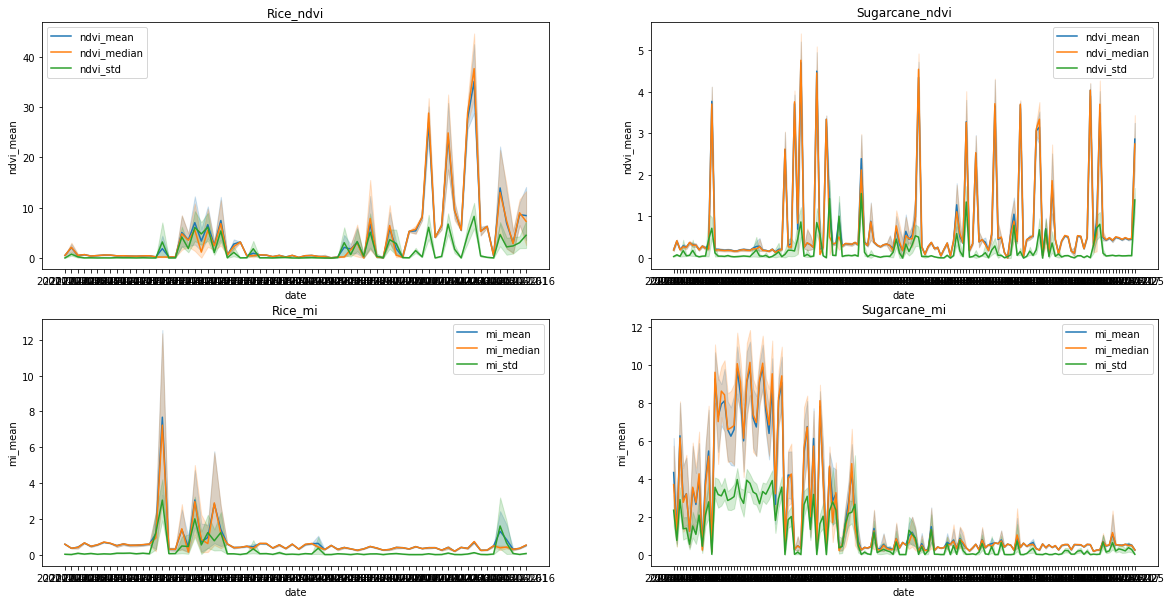

In [33]:
sugarcane = df_viz[df_viz['target']=='sugarcane']
rice = df_viz[df_viz['target']== 'rice_1y']

plt.figure(figsize=(20,10))

# Ndvi Visualization
# Rice
plt.subplot(2, 2, 1)
sns.lineplot(x = "date", y = "ndvi_mean", data = rice, palette = 'blue',label = 'ndvi_mean')
sns.lineplot(x = "date", y = "ndvi_median", data = rice,palette = 'orange',label = 'ndvi_median')
sns.lineplot(x = "date", y = "ndvi_std", data = rice,palette = 'green',label = 'ndvi_std')
plt.title('Rice_ndvi')
# Sugarcane
plt.subplot(2, 2, 2)
sns.lineplot(x = "date", y = "ndvi_mean", data = sugarcane, palette = 'blue',label = 'ndvi_mean')
sns.lineplot(x = "date", y = "ndvi_median", data = sugarcane,palette = 'orange',label = 'ndvi_median')
sns.lineplot(x = "date", y = "ndvi_std", data = sugarcane,palette = 'green',label = 'ndvi_std')
plt.title('Sugarcane_ndvi')

# mi Visualization
# Rice
plt.subplot(2, 2, 3)
sns.lineplot(x = "date", y = "mi_mean", data = rice, palette = 'blue',label = 'mi_mean')
sns.lineplot(x = "date", y = "mi_median", data = rice,palette = 'orange',label = 'mi_median')
sns.lineplot(x = "date", y = "mi_std", data = rice,palette = 'green',label = 'mi_std')
plt.title('Rice_mi')
# Sugarcane
plt.subplot(2, 2, 4)
sns.lineplot(x = "date", y = "mi_mean", data = sugarcane, palette = 'blue',label = 'mi_mean')
sns.lineplot(x = "date", y = "mi_median", data = sugarcane,palette = 'orange',label = 'mi_median')
sns.lineplot(x = "date", y = "mi_std", data = sugarcane,palette = 'green',label = 'mi_std')
plt.title('Sugarcane_mi')

# Cb1 Visualization

# sns.lineplot(x = "date", y = "Cb1_mean", data = rice, hue = 'target')
# sns.lineplot(x = "date", y = "Cb1_median", data = rice)
# sns.lineplot(x = "date", y = "Cb1_std", data = rice)

# sns.lineplot(x = "date", y = "Cb1_mean", data = sugarcane, hue = 'target')
# sns.lineplot(x = "date", y = "Cb1_median", data = sugarcane)
# sns.lineplot(x = "date", y = "Cb1_std", data = sugarcane)


# Cb2 Visualization

# sns.lineplot(x = "date", y = "Cb2_mean", data = rice, hue = 'target')
# sns.lineplot(x = "date", y = "Cb2_median", data = rice)
# sns.lineplot(x = "date", y = "Cb2_std", data = rice)

# sns.lineplot(x = "date", y = "Cb2_mean", data = sugarcane, hue = 'target')
# sns.lineplot(x = "date", y = "Cb2_median", data = sugarcane)
# sns.lineplot(x = "date", y = "Cb2_std", data = sugarcane)


# plt.ylabel("Col_1 and Col_2")
# plt.xticks(rotation = 25)
plt.legend()


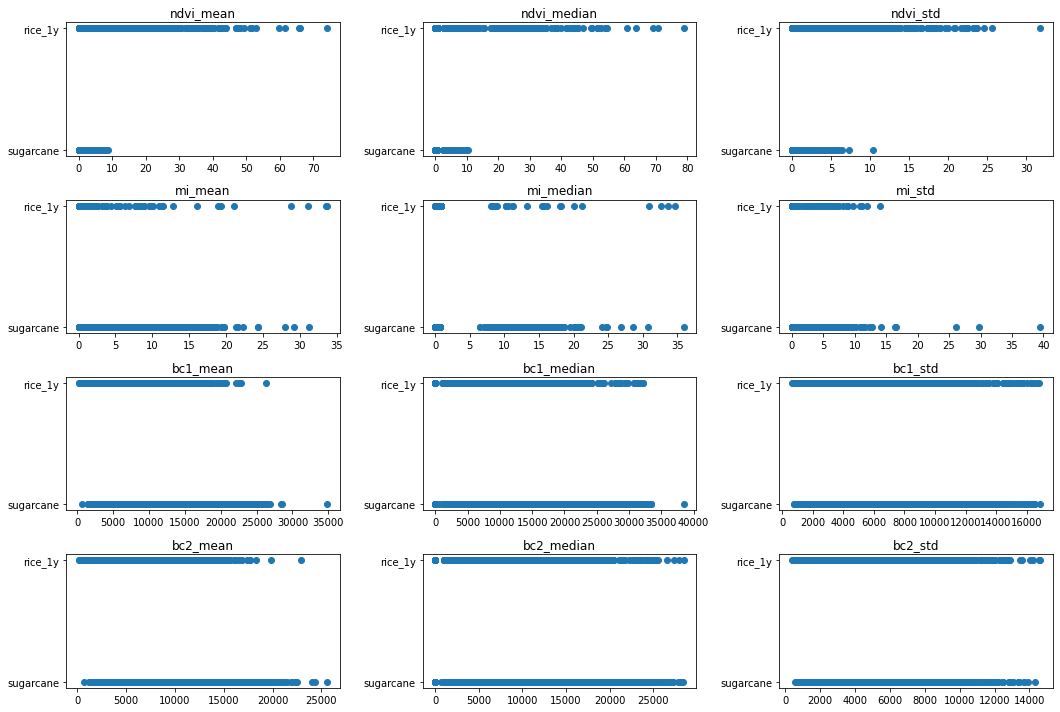

In [35]:
X = df_viz.drop(columns=['target','date','month','id'])
y = df_viz['target']

fig, ax = plt.subplots(4, 3, figsize=(15,10), tight_layout=True, )

#Ndvi
ax[0,0].scatter(X.ndvi_mean, y)
ax[0,0].set_title('ndvi_mean')
ax[0,1].scatter(X.ndvi_median, y)
ax[0,1].set_title('ndvi_median')
ax[0,2].scatter(X.ndvi_std, y)
ax[0,2].set_title('ndvi_std')

#mi
ax[1,0].scatter(X.mi_mean, y)
ax[1,0].set_title('mi_mean')
ax[1,1].scatter(X.mi_median, y)
ax[1,1].set_title('mi_median')
ax[1,2].scatter(X.mi_std, y)
ax[1,2].set_title('mi_std')

#Cb1
ax[2,0].scatter(X.bc1_mean, y)
ax[2,0].set_title('bc1_mean')
ax[2,1].scatter(X.bc1_median, y)
ax[2,1].set_title('bc1_median')
ax[2,2].scatter(X.bc1_std, y)
ax[2,2].set_title('bc1_std')

#Cb2
ax[3,0].scatter(X.bc2_mean, y)
ax[3,0].set_title('bc2_mean')
ax[3,1].scatter(X.bc2_median, y)
ax[3,1].set_title('bc2_median')
ax[3,2].scatter(X.bc2_std, y)
ax[3,2].set_title('bc2_std')

plt.show()

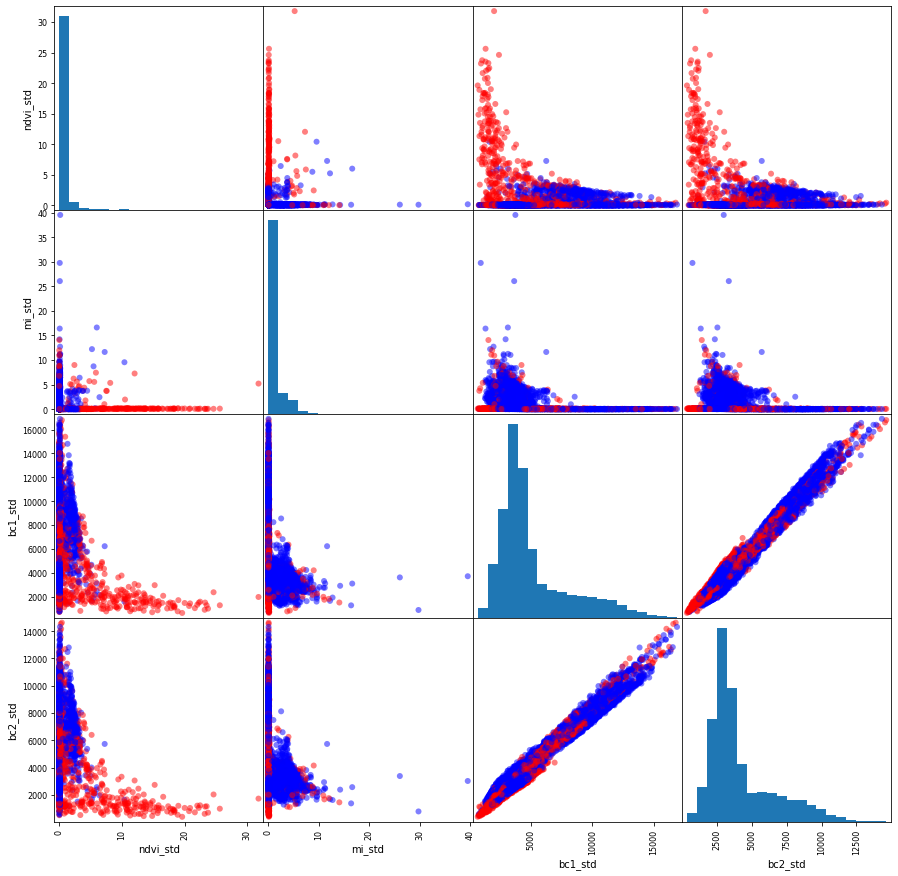

In [36]:
X = df_viz.drop(columns='target')
y = df_viz['target']
pd.plotting.scatter_matrix(X.iloc[:,[3,6,9,12]], alpha=0.5, color=['blue' if t == 'sugarcane' else 'red' for t in y], figsize=(15,15), marker='o', hist_kwds={'bins':20});

# Prevent Data Leaking (df2: ndvi, mi, bc1-bc3, band 1 ~12)

In [38]:
df2 = df.copy()
# remove_columns = ['bc4_mean', 'bc4_median', 'bc4_std', 'bc5_mean',
#        'bc5_median', 'bc5_std', 'bc6_mean', 'bc6_median', 'bc6_std',
#        'bc8_mean', 'bc8_median', 'bc8_std', 'bc9_mean', 'bc9_median',
#        'bc9_std', 'bc10_mean', 'bc10_median', 'bc10_std', 'bc11_mean',
#        'bc11_median', 'bc11_std', 'bc12_mean', 'bc12_median', 'bc12_std',
#        'bc13_mean', 'bc13_median', 'bc13_std', 'bc14_mean', 'bc14_median',
#        'bc14_std', 'bc15_mean', 'bc15_median', 'bc15_std', 'bc16_mean',
#        'bc16_median', 'bc16_std']
# df2 = df2.drop(columns = remove_columns )
df2

,date,id,target,ndvi_mean,ndvi_std,ndvi_median,mi_mean,mi_std,mi_median,bc1_mean,bc1_std,bc1_median,bc2_mean,bc2_std,bc2_median,bc3_mean,bc3_std,bc3_median,b0_mean,b0_std,b0_median,b1_mean,b1_std,b1_median,b2_mean,b2_std,b2_median,b3_mean,b3_std,b3_median,b4_mean,b4_std,b4_median,b5_mean,b5_std,b5_median,b6_mean,b6_std,b6_median,b7_mean,b7_std,b7_median,b8_mean,b8_std,b8_median,b9_mean,b9_std,b9_median,b10_mean,b10_std,b10_median,b11_mean,b11_std,b11_median,b12_mean,b12_std,b12_median,month
0,2021-01-29,id_6054a1b558a7cd00480009c5,sugarcane,0.326887,0.039961,0.333059,0.356040,0.056311,0.370403,6652.833333,2462.498480,7553.5,5229.897959,1934.456072,5927.0,14.665329,0.653275,14.544327,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,0.880952,0.323845,1.0,1
1,2021-01-01,id_6054a1b558a7cd00480009cb,sugarcane,0.389033,0.085019,0.370453,0.388601,0.084351,0.389844,5773.906250,3424.335217,7599.0,4326.007812,2560.718544,5744.5,14.795292,0.850183,14.604716,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
2,2021-01-31,id_6054a1b558a7cd00480009cb,sugarcane,0.231330,0.081022,0.187807,4.498033,5.008589,0.353001,5645.617188,3338.367818,7462.5,5365.093750,3213.801262,7079.5,13.631533,0.898252,13.511060,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,0.742188,0.437430,1.0,1
3,2021-01-16,id_6054a1b558a7cd00480009b0,sugarcane,0.802878,5.477423,0.047894,24.260523,8.707744,26.798188,2048.275815,1866.452851,2513.5,2257.058424,1955.437476,2828.5,33.738232,8.489666,37.437929,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,0.614130,0.486800,1.0,1
4,2021-01-19,id_6054a1b558a7cd00480009d7,sugarcane,0.314713,0.077776,0.302136,0.322170,0.149583,0.303254,4964.931429,4011.322661,7860.0,3879.786667,3163.837463,5743.0,13.606075,0.914013,13.754336,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,0.606667,0.488490,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7788,2020-12-26,id_60a09545f85c5e001b8714ba,rice_1y,6.889612,4.426219,9.179983,0.097189,0.009057,0.097371,2701.352881,4435.784458,0.0,2550.419753,4187.098316,0.0,9.973318,1.533205,10.034206,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,0.272634,0.445314,0.0,12
7789,2020-12-05,id_6054a1b558a7cd00480009c8,sugarcane,0.447698,0.063686,0.453211,0.431491,0.095524,0.415568,5331.385185,3299.993786,7188.5,3981.037037,2447.727538,5284.5,15.914297,1.543560,15.472933,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444151,1.0,0.729630,0.444

In [39]:
#GroupShuffleSplit
from sklearn.model_selection import GroupShuffleSplit
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df2, groups=df2['id']))
train = df2.iloc[train_inds]
test = df2.iloc[test_inds]

In [40]:
A = train.id.unique()
B = test.id.unique()
bool(set(A).intersection(B))

False

# Learning Curve

In [41]:
X_train = train.drop(columns = ['target','month', 'date','id'])
y_train= train['target']

X_test = test.drop(columns = ['target','month', 'date','id'])
y_test = test['target']

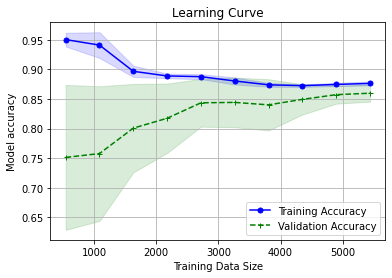

In [42]:
pipeline = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', solver='lbfgs', random_state=1, max_iter=10000))

# pipeline = make_pipeline(StandardScaler(),
#                         KNeighborsClassifier())

# Use learning curve to get training and test scores along with train sizes

train_sizes, train_scores, test_scores = learning_curve(estimator=pipeline, X=X_train, y=y_train,
                                                       cv=10, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1)

#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Train Model

In [44]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

sc = RobustScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

pca = PCA()
X_train_all = pca.fit_transform(X_train_sc)
X_test_all = pca.transform(X_test_sc)

knn = KNeighborsClassifier(n_neighbors=3, leaf_size = 1, p = 1)
knn.fit(X_train_all, y_train)

y_pred = knn.predict(X_test_all)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy',accuracy_score(y_test, y_pred))

[[ 208   80]
 [  69 1391]]
Accuracy 0.9147597254004577


In [45]:
#List Hyperparameters that we want to tune.
from sklearn.model_selection import GridSearchCV
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train_all,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 3
